In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from os import listdir
from sklearn.metrics import det_curve

In [9]:
train = []
dev = []
dire = 'D:/College/PRML/Assgn 3/DTW/Sound/'
for path in ['3', '5', '8', '9', 'o']:
    files = listdir(dire+path+'/train')
    temp = []
    for file in files:
        if file[-4:] == 'mfcc':
            l = []
            i = 0
            for line in open(dire+path+'/train/'+file).readlines():
                if i==0:
                    i += 1
                    continue                
                l.append(line.split())
                i += 1
            temp.append(np.array(l, dtype=np.float64))
    train.append(temp)
    
for path in ['3', '5', '8', '9', 'o']:
    files = listdir(dire+path+'/dev')
    temp = []
    for file in files:
        if file[-4:] == 'mfcc':
            l = []
            i = 0
            for line in open(dire+path+'/dev/'+file).readlines():
                if i==0:
                    i += 1
                    continue                
                l.append(line.split())
                i += 1
            temp.append(np.array(l, dtype=np.float64))
    dev.append(temp)

In [8]:
train[0][0]

array([[-2.907248  , -2.489038  ,  0.4477482 , ...,  0.1881245 ,
         0.09903693,  0.2012774 ],
       [-3.320479  , -2.901215  , -0.5612812 , ...,  0.1637295 ,
         0.1027453 ,  0.1131358 ],
       [-3.057733  , -3.511534  , -0.475153  , ...,  0.07195882,
         0.1277423 ,  0.07814889],
       ...,
       [-2.384042  , -3.653849  , -1.354536  , ...,  0.00638086,
         0.06744456,  0.03511511],
       [-3.638531  , -2.060457  , -0.1351986 , ..., -0.03885906,
         0.07153434, -0.03284477],
       [-3.443068  , -2.954859  , -0.04419899, ..., -0.1141912 ,
         0.03965587, -0.04125351]])

In [12]:
def dtw(A, B, window=50):
    n, m = A.shape[0], B.shape[0]
    w = max(window, abs(n-m))
    dtw_matrix = np.zeros((n+1, m+1))
    
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0.0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            dtw_matrix[i, j] = 0.0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            cost = np.linalg.norm(A[i-1] - B[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
            
    return dtw_matrix[n, m]

In [14]:
dtw(train[2][1] , train[1][2])

722.2554269902073

In [36]:
predictions = []
probabilities = []
with tqdm(total = 5*39*5*12) as pbar:
    for i in tqdm(range(5), disable=True):
        for j in tqdm(range(len(dev[i])), disable=True):
            distances = []
            temp = []
            for p in tqdm(range(5), disable=True):            
                scores = []
                for q in tqdm(range(len(train[p])), disable=True):
                    score = dtw(train[p][q], dev[i][j])
                    scores.append(score)
                    pbar.update(1)
                distances.append(sum(sorted(scores)[:10]))
                temp.append(1/distances[p])
            probabilities.append(temp)
            predictions.append(distances.index(min(distances)))

100%|████████████████████████████████████████████████████████████████████████████| 11700/11700 [32:29<00:00,  6.00it/s]


In [37]:
store = list(probabilities)

In [49]:
for i in range(12*5):
    summ = 0
    for j in range(5):
        summ += probabilities[i][j]
    for j in range(5):
        probabilities[i][j] /= summ

In [40]:
def ROC(probabilities, C, n_classes, Actual):
    n = len(probabilities)
    S = [[probabilities[i][j]* C[j] for j in range (n_classes)] for i in range(n)]
    TPR = []; FPR = []

    for threshold in np.linspace(np.min(S), np.max(S), 1000):
        TP = FP = TN = FN = 0.0

        for i in range (n):

            for j in range (n_classes):

                if(S[i][j] >= threshold):

                    if Actual[i] == j:

                        TP += 1

                    else:

                        FP += 1

                else:

                    if Actual[i] == j:

                        FN += 1

                    else:

                        TN += 1

        TPR.append(TP/(TP + FN))

        FPR.append (FP/(FP+ TN))

    FPR, TPR = zip(*sorted (zip (FPR, TPR)))
    plt.plot (FPR, TPR)
    return np.trapz (TPR, FPR)

0.9926736111111111

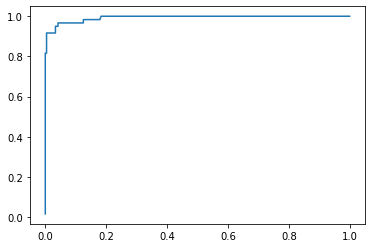

In [51]:
Actual = []
for i in range(5):
    Actual += [i]*12
ROC(probabilities, [0.2,0.2,0.2,0.2,0.2], 5, Actual)

In [52]:
df_confusion = pd.crosstab(np.array(Actual), np.array(predictions))#, rownames=['Actual'], colnames=['Predicted'])
df_confusion

col_0,0,1,2,3,4
row_0,,,,,
0,11,0,1,0,0
1,0,11,0,0,1
2,0,0,12,0,0
3,0,0,0,11,1
4,0,0,0,0,12


In [55]:
count_correct = 0
total = 0
total = len(predictions)
for i in range(12*5):
    if predictions[i] == Actual[i]:
        count_correct += 1
print('Accuracy: ', count_correct/total)

Accuracy:  0.95
